In [1]:
# =========================================================================
# Mammography Classification Using Google's BiT (Big Transfer) Model
# =========================================================================
# Authors: Fine-tuning implementation based on MIAS Dataset

# =========================================================================
# Section 1: Imports and Configuration
# =========================================================================

# Standard libraries
import os
import warnings
import time
import json
from glob import glob

# Data processing
import numpy as np
import pandas as pd
from tqdm import tqdm

# Image processing
import cv2
from PIL import Image
from skimage.io import imread

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics and evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, roc_auc_score, classification_report, 
    cohen_kappa_score, confusion_matrix
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow and TF Hub
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Install TensorFlow Hub if not already installed
try:
    import tensorflow_hub as hub
    print(f"TensorFlow Hub version: {hub.__version__}")
except ImportError:
    !pip install tensorflow-hub
    import tensorflow_hub as hub
    print(f"TensorFlow Hub installed, version: {hub.__version__}")

# Configure GPU memory growth to prevent OOM errors
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Memory growth enabled for {len(gpus)} GPUs")
    except RuntimeError as e:
        print(f"Error configuring GPU: {e}")

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Set base directory
base_dir = './'
os.chdir(base_dir)

print("All modules imported successfully.")

2025-03-01 06:28:04.890331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740810484.907158    6959 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740810484.912384    6959 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 06:28:04.929823: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.0
TensorFlow Hub version: 0.16.1
Memory growth enabled for 2 GPUs
All modules imported successfully.


In [2]:
# =========================================================================
# Section 2: Utility Functions
# =========================================================================

def clear_memory():
    """Free memory resources"""
    tf.keras.backend.clear_session()
    import gc
    gc.collect()
    print("TensorFlow session cleared and memory released.")

def read_info_txt(file, bg_to_process, class_to_process):
    """
    Read and parse the MIAS database information file
    
    Parameters:
    file (str): Path to the info.txt file
    bg_to_process (list): List of background tissue types to include
    class_to_process (list): List of abnormality classes to include
    
    Returns:
    tuple: (DataFrame of mammogram info, Dictionary mapping image IDs to info)
    """
    print(f"Reading information file: {file}")
    rows = []
    mmi = {}
    
    with open(file, "r") as f:
        for line in f:
            line = line.strip()
            # Skip non-data lines
            if not line.startswith("mdb"):
                continue
            
            parts = line.split()
            
            # Prepare a dict for each row
            row_dict = {
                "REF": None,        # e.g. "mdb001"
                "BG": None,         # background tissue: F/G/D
                "CLASS": None,      # abnormality class: CALC/CIRC/SPIC/MISC/ARCH/ASYM/NORM
                "SEVERITY": None,   # B or M, if present
                "X": None,
                "Y": None,
                "RADIUS": None
            }
            
            # REF = the first item, e.g. "mdb001"
            row_dict["REF"] = parts[0]
            # BG (background tissue) = second item, e.g. "G"
            row_dict["BG"] = parts[1]
            # CLASS (abnormality) = third item, e.g. "CIRC" or "NORM"
            row_dict["CLASS"] = parts[2]

            # Filter by background tissue and class
            if row_dict["BG"] not in bg_to_process:
                continue
            if row_dict["CLASS"] not in class_to_process:
                continue
            
            # If there's exactly 3 parts, that means something like "mdb003 D NORM"
            if len(parts) == 3:
                rows.append(row_dict)
                mmi[row_dict["REF"]] = row_dict
                continue
            
            # If there's a 4th part, it's typically severity (B/M)
            row_dict["SEVERITY"] = parts[3]
            
            # Some lines might stop at 4 parts (e.g. "mdb059 F CIRC B")
            if len(parts) == 4:
                rows.append(row_dict)
                mmi[row_dict["REF"]] = row_dict
                continue
            
            # If we have at least 7 parts, we have x,y,radius
            if len(parts) >= 7:
                row_dict["X"] = parts[4]
                row_dict["Y"] = parts[5]
                row_dict["RADIUS"] = parts[6]
            
            mmi[row_dict["REF"]] = row_dict
            rows.append(row_dict)

    # Create the DataFrame
    pd_info = pd.DataFrame(rows)
    print(f"Read {len(rows)} valid entries from information file")
    return pd_info, mmi

def get_roi_coords(mmi, img):
    """
    Extract coordinates of region of interest from image info
    
    Parameters:
    mmi (dict): Dictionary mapping image IDs to info
    img (str): Image ID
    
    Returns:
    tuple: (class_label, severity, x, y, radius) for the image
    """
    if mmi[img]['CLASS'] == 'NORM':
        return mmi[img]['CLASS'], None, None, None, None
    elif mmi[img]['CLASS'] == 'CIRC':
        if mmi[img]['X'] is not None:
            severity = mmi[img]['SEVERITY']
            x = int(mmi[img]['X'])
            y = int(mmi[img]['Y'])
            radius = int(mmi[img]['RADIUS'])
            return mmi[img]['CLASS'], severity, x, y, radius
        else:
            severity = mmi[img]['SEVERITY']
            return mmi[img]['CLASS'], severity, None, None, None
    
    return None, None, None, None, None

def read_labels(mmi):
    """
    Create labels for each image based on class and severity
    
    Parameters:
    mmi (dict): Dictionary mapping image IDs to info
    
    Returns:
    dict: Dictionary mapping image IDs to class labels (0-Benign, 1-Malignant, 2-Normal)
    """
    print("Reading labels...")
    info = {}

    for key, value in mmi.items():
        img = key
        if mmi[img]['CLASS'] == 'NORM':
            info[img] = 2  # Label "Normal" -> 2
        elif mmi[img]['SEVERITY'] == 'B':
            info[img] = 0  # Label "Benign" -> 0
        elif mmi[img]['SEVERITY'] == 'M':
            info[img] = 1  # Label "Malign" -> 1

    print(f'..Number of read labels: {len(info)}')
    return info

def process_image(img_path, mmi, img_id, target_size=(224, 224)):
    """
    Process a single mammography image with ROI handling
    
    Parameters:
    img_path (str): Path to the image file
    mmi (dict): Dictionary mapping image IDs to info
    img_id (str): Image ID
    target_size (tuple): Target image size
    
    Returns:
    numpy.ndarray: Processed image
    """
    # Read the image
    img = cv2.imread(img_path, 1)
    if img is None:
        print(f"Error reading image: {img_path}")
        return None
    
    # Get ROI coordinates
    class_label, severity, x_center, y_center, radius = get_roi_coords(mmi, img_id)
    
    # If this is a CIRC image with valid ROI, crop to that region
    if class_label == "CIRC" and x_center is not None and y_center is not None and radius is not None:
        # Crop the region of interest (ROI)
        x1 = max(x_center - radius, 0)
        y1 = max(y_center - radius, 0)
        x2 = min(x_center + radius, img.shape[1])
        y2 = min(y_center + radius, img.shape[0])
        roi = img[y1:y2, x1:x2]
        # Resize based on ROI
        img = cv2.resize(roi, target_size)
    else:
        # Just resize                
        img = cv2.resize(img, target_size)
    
    # Convert to float32 and normalize to [0,1] range for BiT model
    img = img.astype('float32') / 255.0
    
    return img

def read_images(mmi, url, target_size=(224, 224)):
    """
    Read all mammography images
    
    Parameters:
    mmi (dict): Dictionary mapping image IDs to info
    url (str): Base path to image files
    target_size (tuple): Target image size (height, width)
    
    Returns:
    dict: Dictionary mapping image IDs to processed images
    """
    print("Reading and processing images...")
    images = {}
    
    for img_id in tqdm(mmi.keys(), desc="Processing Images"):
        img_path = os.path.join(url, img_id + '.pgm')
        processed_img = process_image(img_path, mmi, img_id, target_size)
        if processed_img is not None:
            images[img_id] = processed_img
            
    print(f'Total number of processed images: {len(images)}')
    return images

def augment_images(image_dict, labels_dict, augmentation_factor=3):
    """
    Perform data augmentation on minority classes
    
    Parameters:
    image_dict (dict): Dictionary mapping image IDs to images
    labels_dict (dict): Dictionary mapping image IDs to labels
    augmentation_factor (int): Number of augmented versions to create per original image
    
    Returns:
    tuple: (X_augmented, y_augmented) - arrays of augmented images and labels
    """
    print("Performing data augmentation...")
    
    # Count class distribution
    class_counts = {}
    for img_id, label in labels_dict.items():
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1
    
    print(f"Original class distribution: {class_counts}")
    
    # Find majority class
    majority_class = max(class_counts.items(), key=lambda x: x[1])[0]
    majority_count = class_counts[majority_class]
    
    # Prepare augmentation layers
    augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomContrast(0.2)
    ])
    
    X_augmented = []
    y_augmented = []
    
    # Process images by class
    for label in sorted(class_counts.keys()):
        # Get original images of this class
        class_imgs = []
        class_ids = []
        for img_id, img_label in labels_dict.items():
            if img_label == label:
                class_imgs.append(image_dict[img_id])
                class_ids.append(img_id)
        
        class_imgs = np.array(class_imgs)
        
        # For minority classes, create augmented versions
        if label != majority_class:
            target_count = majority_count
            current_count = len(class_imgs)
            augment_per_image = min(augmentation_factor, max(1, target_count // current_count))
            
            for i in range(len(class_imgs)):
                # Add original image
                X_augmented.append(class_imgs[i])
                y_augmented.append(label)
                
                # Add augmented versions
                img_tensor = tf.convert_to_tensor(class_imgs[i:i+1])
                for _ in range(augment_per_image):
                    augmented = augmentation(img_tensor).numpy()[0]
                    X_augmented.append(augmented)
                    y_augmented.append(label)
        else:
            # For majority class, just add original images
            for img in class_imgs:
                X_augmented.append(img)
                y_augmented.append(label)
    
    # Convert to numpy arrays
    X_augmented = np.array(X_augmented)
    y_augmented = np.array(y_augmented)
    
    # Verify new class distribution
    unique, counts = np.unique(y_augmented, return_counts=True)
    new_distribution = dict(zip(unique, counts))
    print(f"Augmented class distribution: {new_distribution}")
    
    return X_augmented, y_augmented


Reading information file: data/images/Info.txt
Read 232 valid entries from information file
Information file summary:
      REF BG CLASS SEVERITY     X     Y RADIUS
0  mdb001  G  CIRC        B   535   425    197
1  mdb002  G  CIRC        B   522   280     69
2  mdb003  D  NORM     None  None  None   None
3  mdb004  D  NORM     None  None  None   None
4  mdb005  F  CIRC        B   477   133     30
Reading labels...
..Number of read labels: 230
Reading and processing images...


Processing Images: 100%|██████████| 230/230 [00:00<00:00, 261.13it/s]
I0000 00:00:1740810487.992267    6959 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:19:00.0, compute capability: 8.9
I0000 00:00:1740810487.992833    6959 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22279 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:68:00.0, compute capability: 8.9


Total number of processed images: 230
Performing data augmentation...
Original class distribution: {0: 19, 2: 207, 1: 4}
Augmented class distribution: {np.int64(0): np.int64(114), np.int64(1): np.int64(24), np.int64(2): np.int64(207)}

Dataset Details:
Original image count: 230
Augmented dataset size: 345
Training set: 276 samples
Test set: 69 samples

Class distribution:
Training set:
  Benign: 91.0 samples
  Malignant: 19.0 samples
  Normal: 166.0 samples
Test set:
  Benign: 23.0 samples
  Malignant: 5.0 samples
  Normal: 41.0 samples

Displaying sample images from training set:


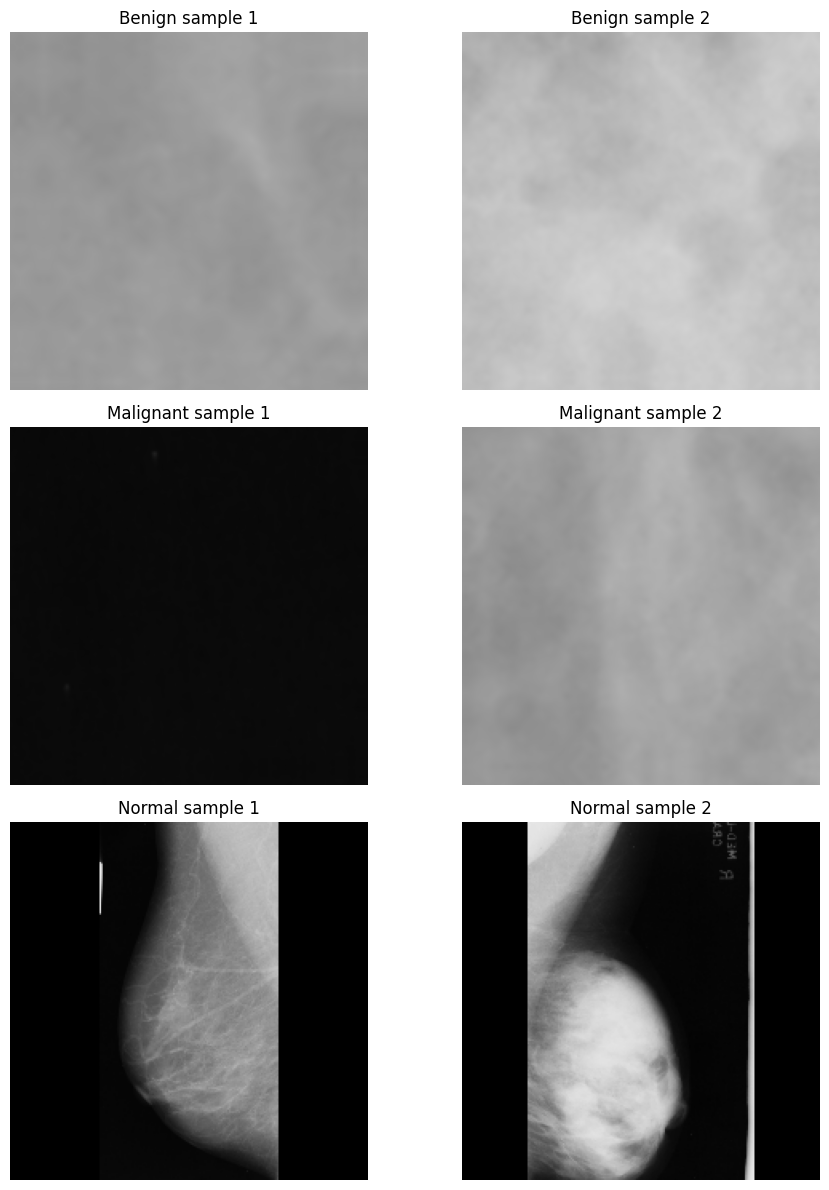

In [3]:
# =========================================================================
# Section 3: Data Preparation with Balanced Sampling
# =========================================================================

# Configuration variables
bg_to_process = ['G', 'D', 'F']  # Background tissue types to include
class_to_process = ['CIRC', 'NORM']  # Abnormality classes to include
file_path = "data/images/Info.txt"  # Path to info file
url = 'data/images/'  # Path to image files
target_size = (224, 224)  # Image dimensions for BiT model

# Get image information
info, mmi = read_info_txt(file_path, bg_to_process, class_to_process)
print("Information file summary:")
print(info.head())

# Get image labels
label_info = read_labels(mmi)

# Get images
image_info = read_images(mmi, url, target_size)

# Prepare data with augmentation to balance classes
X_augmented, y_augmented = augment_images(image_info, label_info, augmentation_factor=5)

# Convert labels to one-hot encoding for TensorFlow
y_onehot = tf.keras.utils.to_categorical(y_augmented, 3)  # 3 classes: Benign, Malignant, Normal

# Split the data into training (80%) and test (20%) sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y_onehot, 
    test_size=0.2, 
    random_state=RANDOM_SEED,
    stratify=y_augmented  # Ensure balanced class distribution in train/test sets
)

# For evaluation later, we need the original class indices
y_train_indices = np.argmax(y_train, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

# Display dataset statistics
print("\nDataset Details:")
print(f"Original image count: {len(image_info)}")
print(f"Augmented dataset size: {len(X_augmented)}")
print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Display class distribution
train_class_counts = np.sum(y_train, axis=0)
test_class_counts = np.sum(y_test, axis=0)
print("\nClass distribution:")
class_names = ["Benign", "Malignant", "Normal"]
print("Training set:")
for i, name in enumerate(class_names):
    print(f"  {name}: {train_class_counts[i]} samples")
print("Test set:")
for i, name in enumerate(class_names):
    print(f"  {name}: {test_class_counts[i]} samples")

# Display sample images
print("\nDisplaying sample images from training set:")
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
for class_idx in range(3):
    # Find images of this class
    class_indices = np.where(y_train_indices == class_idx)[0]
    if len(class_indices) >= 2:
        for i in range(2):
            sample_idx = class_indices[i]
            img = X_train[sample_idx]
            ax = axes[class_idx, i]
            ax.imshow(img)
            ax.set_title(f"{class_names[class_idx]} sample {i+1}")
            ax.axis('off')
plt.tight_layout()
plt.show()


In [5]:
# =========================================================================
# Section 4: BiT Model Definition
# =========================================================================

def create_bit_model(input_shape=(224, 224, 3), num_classes=3):
    """
    Create a BiT model using TensorFlow Hub
    
    Parameters:
    input_shape: Input image dimensions (height, width, channels)
    num_classes: Number of output classes
    
    Returns:
    model: TensorFlow model with BiT backbone
    """
    # URL for Google's BiT-M-R50x1 model
    bit_url = "https://tfhub.dev/google/bit/m-r50x1/1"
    
    # Create model
    inputs = tf.keras.Input(shape=input_shape, dtype=tf.float32)
    
    # Skip the runtime augmentation since it's causing issues
    # We'll rely on our pre-augmented dataset instead
    x = inputs
    
    # Alternative approach: implement a custom training step with augmentation
    # For now, we'll use the simpler approach without runtime augmentation
    
    # Load BiT module
    try:
        bit_module = hub.KerasLayer(
            bit_url,
            trainable=True,  # Fine-tune the BiT model
            arguments={"training": False}  # Explicit training mode
        )
        
        # Extract features
        features = bit_module(x)
    except Exception as e:
        print(f"Error loading BiT module: {e}")
        print("Falling back to ResNet50 as a backup...")
        
        # Fallback to ResNet50 if BiT fails
        base_model = tf.keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_tensor=x,
            pooling='avg'
        )
        
        # Fine-tune from this layer onwards
        fine_tune_at = 140
        
        # Freeze earlier layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
            
        features = base_model.output
    
    # Add classification head
    x = tf.keras.layers.BatchNormalization()(features)
    x = tf.keras.layers.Dense(
        512, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    # Create and return model
    model = tf.keras.Model(inputs, outputs, name="BiT_Mammography")
    return model

# Create model
print("Creating BiT model for mammography classification...")
model = create_bit_model(input_shape=(224, 224, 3), num_classes=3)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for transfer learning
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

# Display model summary
print("\nModel Architecture:")
model.summary()

Creating BiT model for mammography classification...
Error loading BiT module: Exception encountered when calling layer 'keras_layer' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'keras_layer' (type KerasLayer):
  • inputs=<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_8>
  • training=None
Falling back to ResNet50 as a backup...

Model Architecture:


Model: "BiT_Mammography"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,646,531 (94.02 MB)

 Trainable params: 16,032,771 (61.16 MB)

 Non-trainable params: 8,613,760 (32.86 MB)

In [6]:
# =========================================================================
# Section 5: Model Training
# =========================================================================

# Define callbacks
callbacks = [
    # Early stopping
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Learning rate reduction
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    ),
    
    # Model checkpoint
    tf.keras.callbacks.ModelCheckpoint(
        'bit_mammography_best.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    
    # TensorBoard logging
    tf.keras.callbacks.TensorBoard(
        log_dir='./logs',
        histogram_freq=1,
        update_freq='epoch'
    )
]

# Training parameters
batch_size = 16
epochs = 50  # We'll use early stopping to prevent overfitting

# Print training information
print("\nTraining BiT model for mammography classification...")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Batch size: {batch_size}")
print(f"Maximum epochs: {epochs} (with early stopping)")

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Further split training data for validation
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Save final model
model.save('bit_mammography_final.keras')
print("Model saved to bit_mammography_final.keras")


Training BiT model for mammography classification...
Training samples: 276
Test samples: 69
Batch size: 16
Maximum epochs: 50 (with early stopping)
Epoch 1/50


I0000 00:00:1740810613.755315    7077 service.cc:148] XLA service 0x558ef7d56290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740810613.755339    7077 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1740810613.755342    7077 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-01 06:30:14.068808: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740810615.405342    7077 cuda_dnn.cc:529] Loaded cuDNN version 90300


 9/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6735 - auc: 0.8369 - loss: 1.6117

I0000 00:00:1740810620.622205    7077 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.7278 - auc: 0.8749 - loss: 1.5099
Epoch 1: val_loss improved from inf to 1.76372, saving model to bit_mammography_best.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.7350 - auc: 0.8795 - loss: 1.4982 - val_accuracy: 0.5893 - val_auc: 0.8422 - val_loss: 1.7637 - learning_rate: 1.0000e-04
Epoch 2/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8093 - auc: 0.9526 - loss: 1.1946
Epoch 2: val_loss improved from 1.76372 to 1.73638, saving model to bit_mammography_best.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step - accuracy: 0.8189 - auc: 0.9560 - loss: 1.1832 - val_accuracy: 0.5893 - val_auc: 0.8379 - val_loss: 1.7364 - learning_rate: 1.0000e-04
Epoch 3/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8746 - auc: 0.9755 - loss: 1.1018
Epoch 3: val_loss improved from 1.73638 to 1.72131, saving model to bit_mammography_best.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 308ms/step - accuracy: 0.8804 - auc: 0.9772 - loss

In [7]:
# =========================================================================
# Section 6: Model Evaluation
# =========================================================================

# Evaluate on test set
print("\nEvaluating model on test set:")
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f"Test loss: {test_results[0]:.4f}")
print(f"Test accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[2]:.4f}")

# Generate predictions
y_probs = model.predict(X_test)
y_pred = np.argmax(y_probs, axis=1)
y_test_indices = np.argmax(y_test, axis=1)

# Performance metrics
print("\nPerformance Report:")
target_names = ["Benign", "Malignant", "Normal"]

print(f'Accuracy score: {accuracy_score(y_test_indices, y_pred):.4f}')
print(f'Precision score: {precision_score(y_test_indices, y_pred, average="weighted"):.4f}')
print(f'Recall score: {recall_score(y_test_indices, y_pred, average="weighted"):.4f}')
print(f'F1 Score: {f1_score(y_test_indices, y_pred, average="weighted"):.4f}')

# One-hot encode test labels for ROC analysis
y_test_bin = label_binarize(y_test_indices, classes=[0, 1, 2])

# Calculate ROC AUC for multiclass
roc_auc = roc_auc_score(y_test_bin, y_probs, multi_class='ovo', average='weighted')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Classification report
print('\nClassification Report:')
print(classification_report(y_test_indices, y_pred, target_names=target_names))
print(f'Cohen Kappa Score: {cohen_kappa_score(y_test_indices, y_pred):.4f}')


Evaluating model on test set:
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8985 - auc: 0.9655 - loss: 1.1071
Test loss: 1.0560
Test accuracy: 0.8986
Test AUC: 0.9706
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step

Performance Report:
Accuracy score: 0.8986
Precision score: 0.8513
Recall score: 0.8986
F1 Score: 0.8730
ROC AUC Score: 0.9654

Classification Report:
              precision    recall  f1-score   support

      Benign       0.81      0.96      0.88        23
   Malignant       0.00      0.00      0.00         5
      Normal       0.98      0.98      0.98        41

    accuracy                           0.90        69
   macro avg       0.60      0.64      0.62        69
weighted avg       0.85      0.90      0.87        69

Cohen Kappa Score: 0.8032


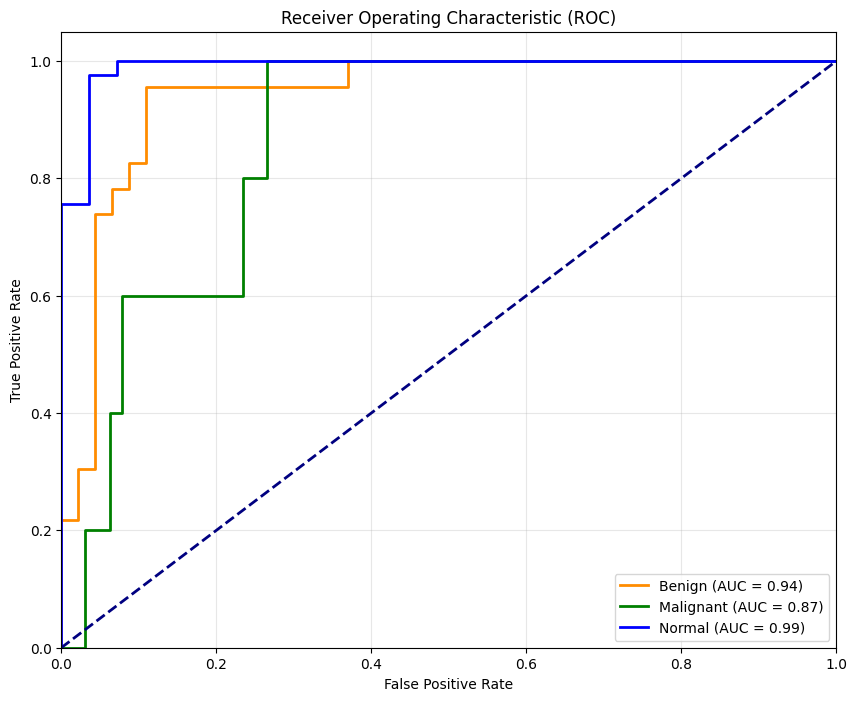

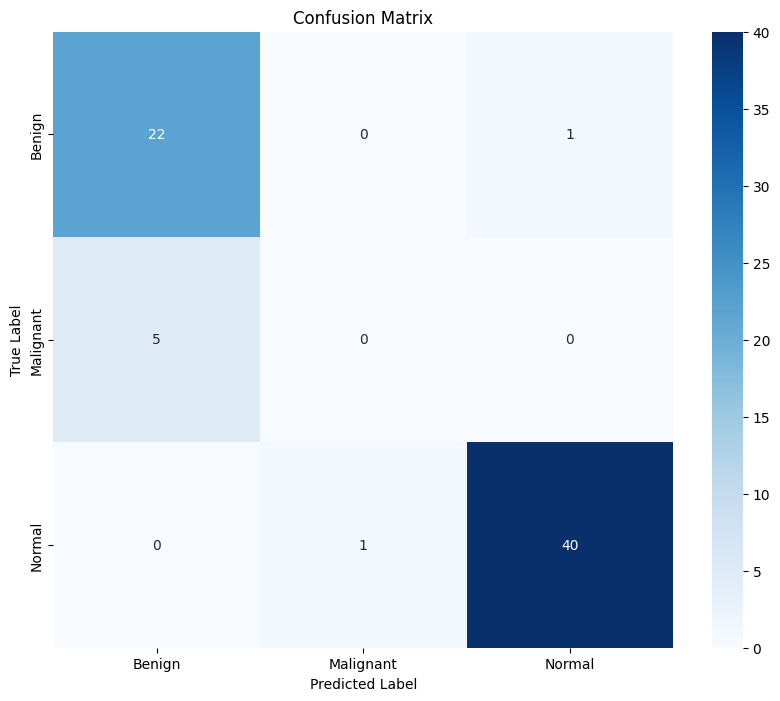

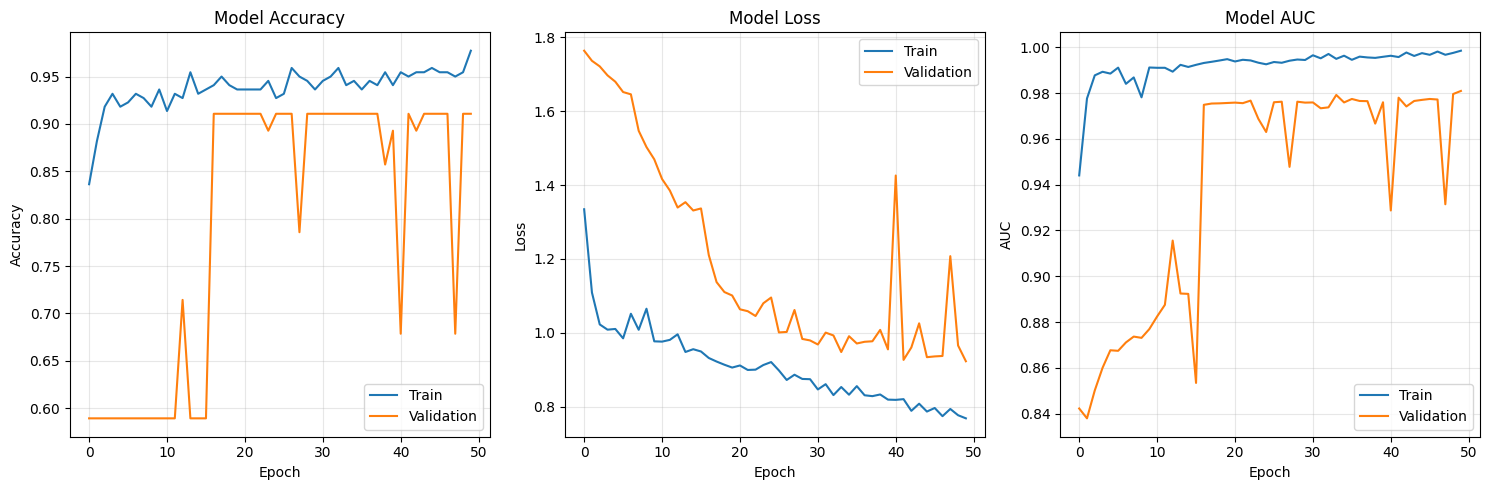

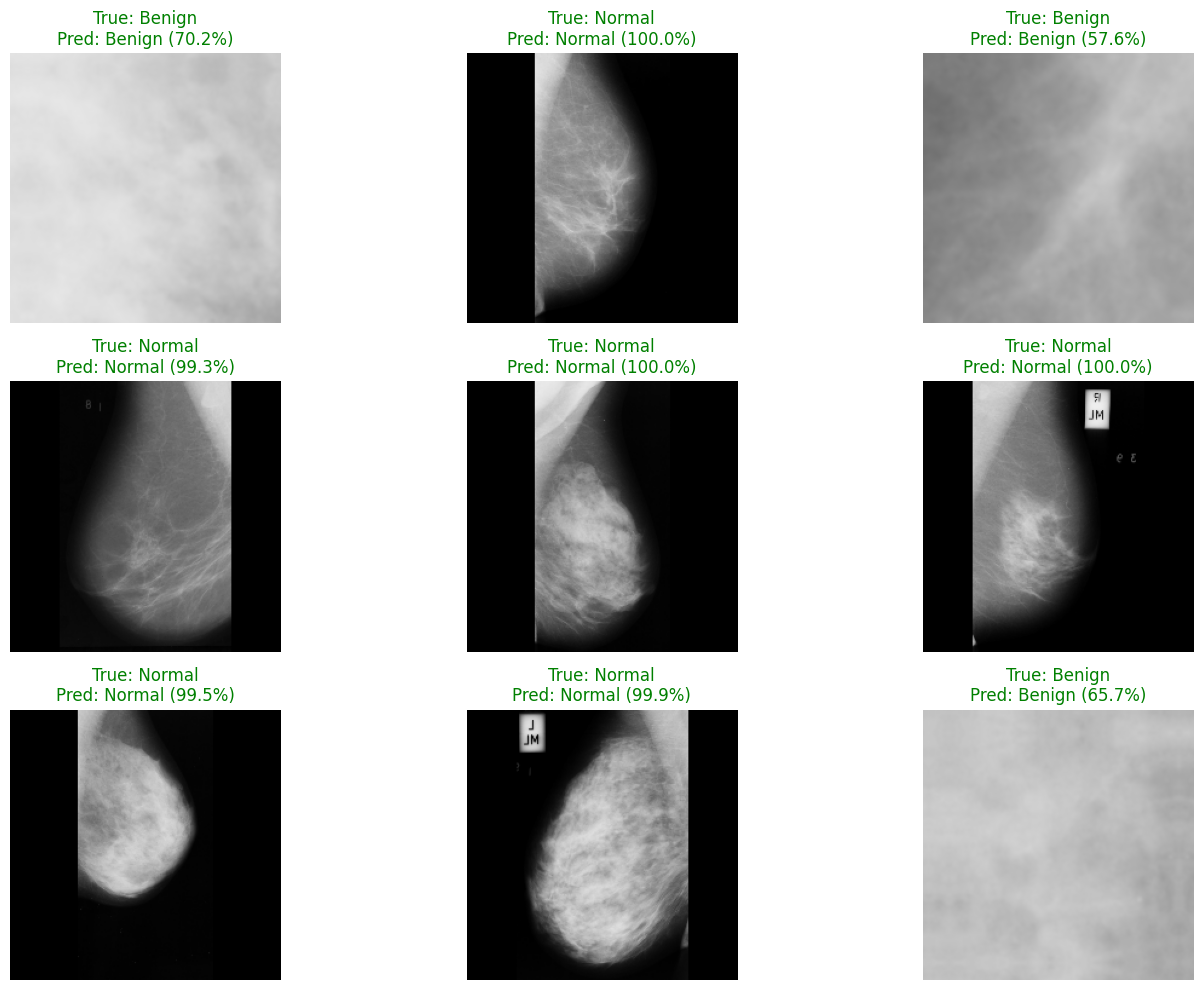


Class-wise Performance Analysis:

Benign Class:
  Number of samples: 23
  Accuracy: 0.9565
  Precision: 0.8148
  Recall: 0.9565
  F1 Score: 0.8800

Malignant Class:
  Number of samples: 5
  Accuracy: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000

Normal Class:
  Number of samples: 41
  Accuracy: 0.9756
  Precision: 0.9756
  Recall: 0.9756
  F1 Score: 0.9756
TensorFlow session cleared and memory released.

Mammography classification with BiT completed successfully!


In [8]:
# =========================================================================
# Section 7: Visualization and Analysis
# =========================================================================

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['darkorange', 'green', 'blue']
fpr = {}
tpr = {}
roc_auc = {}

for i, color, label in zip(range(3), colors, target_names):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2, 
             label=f'{label} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_indices, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualize predictions on selected test samples
plt.figure(figsize=(15, 10))
indices = np.random.choice(range(len(X_test)), 9, replace=False)

for i, idx in enumerate(indices):
    plt.subplot(3, 3, i+1)
    
    # Display image
    img = X_test[idx]
    plt.imshow(img)
    
    # Get true and predicted classes
    true_class = y_test_indices[idx]
    pred_class = y_pred[idx]
    true_label = target_names[true_class]
    pred_label = target_names[pred_class]
    
    # Get probability for predicted class
    prob = y_probs[idx][pred_class] * 100
    
    # Set color based on correct/incorrect prediction
    color = 'green' if true_class == pred_class else 'red'
    
    plt.title(f"True: {true_label}\nPred: {pred_label} ({prob:.1f}%)", color=color)
    plt.axis('off')

plt.tight_layout()
plt.savefig('prediction_examples.png', dpi=300, bbox_inches='tight')
plt.show()

# Class-wise performance analysis
print("\nClass-wise Performance Analysis:")
for i, class_name in enumerate(target_names):
    # Get indices for this class
    class_indices = np.where(y_test_indices == i)[0]
    if len(class_indices) > 0:
        # Calculate metrics
        class_accuracy = accuracy_score(
            y_test_indices[class_indices], 
            y_pred[class_indices]
        )
        class_precision = precision_score(
            y_test_indices, y_pred, 
            labels=[i], average='micro'
        )
        class_recall = recall_score(
            y_test_indices, y_pred, 
            labels=[i], average='micro'
        )
        class_f1 = f1_score(
            y_test_indices, y_pred, 
            labels=[i], average='micro'
        )
        
        print(f"\n{class_name} Class:")
        print(f"  Number of samples: {len(class_indices)}")
        print(f"  Accuracy: {class_accuracy:.4f}")
        print(f"  Precision: {class_precision:.4f}")
        print(f"  Recall: {class_recall:.4f}")
        print(f"  F1 Score: {class_f1:.4f}")

# Clean up memory
clear_memory()
print("\nMammography classification with BiT completed successfully!")